In [1]:
include("notebook_preamble.jl")
using Base.Filesystem;

In [214]:
n = 6;

# Interpolating Hamiltonians

In [215]:
trnorm(A) = sum(svdvals(A)) # tr(√(A' * A))
trnormalize(A) = A / trnorm(A)
∠(A, B) = acos(tr(A' * B)) # For normalized A, B
function normslerp(A, B, g)
    a, b = trnorm(A), trnorm(B)
    A /= a
    B /= b
    θ = ∠(A, B)
    √(a * b) * trnormalize((sin((1-g)*θ)*A + sin(g*θ)*B) / sin(θ))
end
Hinterp(A, B) = g -> normslerp(A, B, g);

The Ising interaction and transverse-field Hamiltonians are

In [216]:
Hx(n) = -sum(siteop(σx, i, n) * siteop(σx, i+1, n) for i in 1:n)
Hz(n) = -sum(siteop(σz, i, n) for i in 1:n)
Hint = Hinterp(Hx(n), Hz(n));

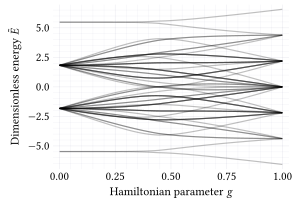

In [217]:
grange(points) = range(1e-3, 1-1e-3, length=points)
lgs = grange(64)
energies = [eigvals(Hint(g)) for g in lgs];
plot(lgs, hcat(energies...)', color=:black, alpha=0.25, key=false, xlabel=L"Hamiltonian parameter $g$", ylabel=L"Dimensionless energy $\tilde{E}$")

In [218]:
savefig("$(tempname(pwd(), cleanup=false))-energy-levels-$(n).pdf")

# Computation of jump operators

In [219]:
function addentry!(dict, key, value; isequal=isequal)
    for k in keys(dict)
        if isequal(k, key)
            push!(dict[k], value)
            return dict
        end
    end
    dict[key] = [value]
    dict
end;

function incentry!(dict, key; isequal=isequal)
    for k in keys(dict)
        if isequal(k, key)
            dict[k] += 1
            return dict
        end
    end
    dict[key] = 1
    dict
end;

firstvalue(i, (x, y)) = x
lastvalue(i, (x, y)) = y
dictmap(f, dict) = Dict(key => f(value) for (key, value) in dict)
function dictby(A; isequal=isequal, keyof=firstvalue, valof=lastvalue)
    i0, x0 = 1, first(A)
    k0, v0 = keyof(i0, x0), valof(i0, x0)
    dict = Dict(k0 => typeof(v0)[])
    dict = Dict()
    for (i, x) in enumerate(A)
        k, v = keyof(i, x), valof(i, x)
        addentry!(dict, k, v, isequal=isequal)
    end
    dict
end;

sumprojector(A) = sum(a * a' for a in A)
projectors(eigdict) = dictmap(sumprojector, eigdict);

function combinejumps(Js)
    d = Dict()
    for J in Js
        incentry!(d, J)
    end
    [√(one(eltype(J)) * N)*J for (J, N) in d]
end;

isequalto(atol=1e-9) = (x, y) -> isapprox(x, y, atol=atol)
function jumps(vals, vecs, As; combine=true, isequal=isequalto())
    eigendict = dictby(zip(vals, vecs))
    ωs = dictby(((E2 - E1, (E1, E2)) for E1 in keys(eigendict), E2 in keys(eigendict)),
        isequal=isequal)
    Πs = projectors(eigendict)
    Jωs = dictmap(ωs) do ΔEs
        filter(x -> !isequal(x, zero(x)),
            [sum(Πs[E1]*A*Πs[E2] for (E1, E2) in ΔEs) for A in As])
    end
    combine ? dictmap(combinejumps, Jωs) : Jωs
end

op_to_spindim(H) = Int(log2(size(H)[1]))
dipole_interactions(n) = vcat(map(A -> [siteop(A, i, n) for i in 1:n], [σx, σy, σz])...)
function dipolejumps(H; kwargs...)
    vals, vecs = eigen(H)
    jumps(vals, eachcol(vecs), dipole_interactions(op_to_spindim(H)); kwargs...)
end;

# Numerical solution of the Lindblad equation

In [220]:
g = 0.5
Hsys = Hint(g)
b = SpinBasis(1//2)
sys = ⊗(repeat([b], n)...)
Jωs = dipolejumps(Hsys)
η = 1e1
α = 1e-2 # Large α means that Lamb shift dominates. For relaxation illustration only.
up = spinup(b)
ψ0 = ⊗(repeat([up], n)...)
ρ0 = projector(ψ0)
op = dense(embed(sys, 1, sigmaz(b)));

In [221]:
jumpops, rates = [], Float64[]
γ(ω, η) = (1e-1 < η*ω ? ω^3 * (1 + 1 / (exp(η*ω) - 1)) : ω^2 / η)
for (ω, Js) in Jωs
    for J in Js
        push!(rates, α * γ(ω, η))
        push!(jumpops, DenseOperator(sys, J))
    end
end

In [222]:
function fout(t, ρ)
    ρ = normalize(ρ)
    real(expect(op, ρ))
end
Hspin = DenseOperator(sys, Hsys)
opth = fout(0.0, thermalstate(Hspin, 1e0))
tf = 2e-1 / (α * γ(1.0, η))
ts = range(0.0, tf, length=501);

In [223]:
_, closed_σzs = timeevolution.schroedinger(ts, ψ0, Hspin; fout=fout)
_, open_σzs   = timeevolution.master(ts, ρ0, Hspin, jumpops; rates=rates, fout=fout)
_, diss_σzs   = timeevolution.master(ts, ρ0, 0*Hspin, jumpops; rates=rates, fout=fout);

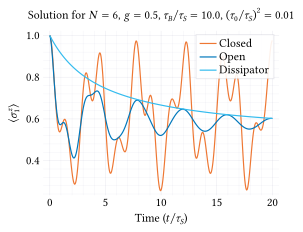

In [224]:
plot(
    title=L"Solution for $N = %$n$, $g = %$g$, $\tau_B / \tau_S = %$η$, ${(\tau_0 / \tau_S)}^2 = %$α$",
    xlabel=L"Time ($t / \tau_S$)",
    ylabel=L"\ev{\pauli_1^z}",
    legend=:topright
)
plot!(ts, [closed_σzs open_σzs diss_σzs], label=["Closed" "Open" "Dissipator"])

In [225]:
savefig("$(tempname(pwd(), cleanup=false))-time-evolution-$(n).pdf")

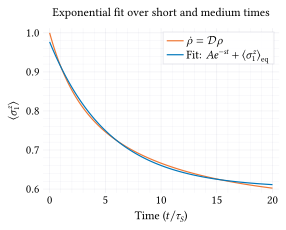

In [226]:
@. decay_exponential(x, p) = diss_σzs[end] + p[1]*exp(x*p[2])
p0 = [1.0, α * γ(1, η)]
fit = curve_fit(decay_exponential, ts, diss_σzs, p0);

plot(ts, diss_σzs, label=L"\dot{\dop} = \sopr{D}\dop",
    legend=:topright,
    title="Exponential fit over short and medium times",
    xlabel=L"Time ($t / \tau_S$)",
    ylabel=L"\ev{\pauli_1^z}")
plot!(ts, decay_exponential(ts, coef(fit)), label=L"Fit: $Ae^{-s t} + \ev{\pauli_1^z}_\text{eq}$")

In [227]:
savefig("$(tempname(pwd(), cleanup=false))-exponential-fit-$(n).pdf")

# Obtaining relaxation from spaghetti (diagrams)

\begin{equation}
    \dop_S(t)
    = \sum_i c_i(0) e^{-s_i t} \opr{V}_i
    \label{eq:liou-decomposition}
\end{equation}

In [228]:
@. decay_exponential(x, p) = p[1]*exp(x*p[2])
function effective_rate(ℒrates, ℒops, ρ0, op, η)
    cs = hcat([vec(V.data) for V in ℒops]...) \ vec(ρ0.data)
    V0s = [tr(op * V) for V in ℒops]
    t0, tf = (0.0, 1e-2) ./ γ(1.0, η)
    ts = range(t0, tf, length=501)
    ys = real(sum(@. c * V0 * exp(real(s)*ts) for (s, c, V0) in zip(ℒrates, cs, V0s)))
    p0 = [1.0, -1.0 / η]
    yf = real(cs[1] * V0s[1])
    fit = curve_fit(decay_exponential, ts, ys .- yf, p0)
    fit.converged || error("Could not fit an effective exponential.")
    coef(fit)[2], stderror(fit)[2]
end

function 𝒟_rates(H, n = op_to_spindim(H); η, ρ0, op)
    Jωs = dipolejumps(H)
    sys = ρ0.basis_r
    jumpops, rates = [], Float64[]
    for (ω, Js) in Jωs
        for J in Js
            push!(rates, γ(ω, η))
            push!(jumpops, DenseOperator(sys, J))
        end
    end
    ℒ = steadystate.liouvillian(0*DenseOperator(sys), jumpops; rates=rates)
    ℒrates, ℒops = steadystate.liouvillianspectrum(ℒ; nev=4^n)
    effrate = effective_rate(ℒrates, ℒops, ρ0, op, η)
    sort(real(ℒrates)), effrate...
end;

In [229]:
function plot_𝒟_rates(Hint;
        points=16, η=1.0, ρ0, op, onplot=false,
        spectrum=true, extremes=true, effective=true,
        kwargs...)
    g0s = grange(points)
    outs = map(g -> 𝒟_rates(Hint(g); η, ρ0, op), g0s)
    rates = [o[1] for o in outs]
    r0 = [o[2] for o in outs]
    σr0 = [o[3] for o in outs]
    
    p = onplot
    if onplot == false
        p = plot(
            xlabel=L"Hamiltonian parameter $g$",
            ylabel=L"Dissipaton rates ($\tilde{\gamma} / \tilde{\gamma}_0$)",
            legendtitle=L"\log\eta",
            legend=:topright;
            kwargs...)
    end
    if spectrum
        plot!(p, g0s, -hcat(rates...)', color=:black, alpha=0.25, label=false)
        
        if extremes
            rates0 = 𝒟_rates(Hint(0); η, ρ0, op)[1]
            rates1 = 𝒟_rates(Hint(1); η, ρ0, op)[1]
            scatter!(p, repeat([g0s[1] - 2e-2], length(rates0)), -rates0,
                marker=(:rtriangle, 2, rubric), markerstrokecolor=rubric, label=false)
            scatter!(p, repeat([g0s[end] + 2e-2], length(rates1)), -rates1,
                marker=(:ltriangle, 2, rubric), markerstrokecolor=rubric, label=false)
        end
    end
    if effective
        plot!(p, g0s, -r0, ribbon=σr0, label=L"%$(round(log10(η), digits=1))",
            color = (onplot == false) ? rubric : :auto)
    end
    p
end;

In [ ]:
plot_𝒟_rates(Hint; η, ρ0, op)

In [ ]:
savefig("$(tempname(pwd(), cleanup=false))-spin-spectrum-$(n).pdf")

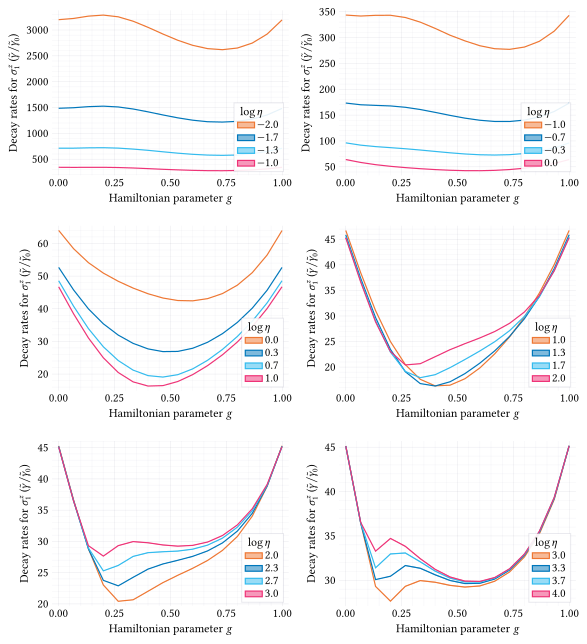

In [182]:
plot([reduce((p, η) ->
            plot_𝒟_rates(Hint; η, ρ0, op, spectrum=false, onplot=p),
            10 .^ range(lη, lη + 1, length=4);
            init = plot(size=2 .* (400, 300 * 3//2),
                xlabel=L"Hamiltonian parameter $g$",
                ylabel=L"Decay rates for $\pauli_1^z$ ($\tilde{\gamma} / \tilde{\gamma}_0$)",
                legend=:bottomright,
                legendtitle=L"\log\eta"))
        for lη in -2:3]...,
    layout=(3,2))

In [183]:
savefig("$(tempname(pwd(), cleanup=false))-spin-relaxation-$(n).pdf")